In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tensorflow.keras.optimizers import Adam

In [2]:
np.random.seed(42)

In [3]:
# Load the Trace dataset
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")

In [4]:
X_train.shape

(100, 275, 1)

In [5]:
y_train

array([1, 2, 4, 3, 1, 4, 4, 1, 1, 4, 4, 4, 4, 3, 4, 1, 3, 2, 4, 4, 4, 4,
       3, 2, 1, 2, 4, 4, 2, 4, 1, 1, 4, 4, 2, 1, 1, 2, 1, 1, 3, 3, 3, 3,
       3, 1, 4, 4, 4, 2, 4, 3, 2, 1, 4, 2, 2, 2, 2, 1, 3, 2, 4, 3, 3, 2,
       2, 1, 4, 4, 2, 3, 2, 1, 3, 4, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 4, 1,
       2, 1, 4, 4, 4, 1, 3, 1, 2, 4, 1, 2], dtype=int64)

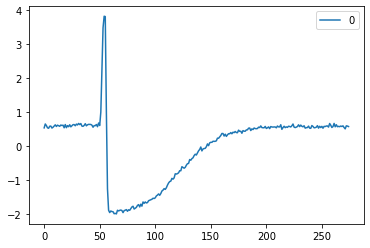

In [6]:
pd.DataFrame(X_train[0]).plot.line();

In [7]:
# Filter out classes 2 and 4
mask = np.isin(y_train, [1, 3])
X_train = X_train[mask]
y_train = y_train[mask]

In [8]:
y_train

array([1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1,
       3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1,
       1, 3, 1, 1], dtype=int64)

In [9]:
# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

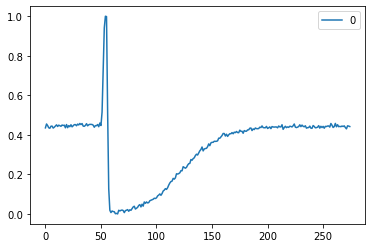

In [10]:
pd.DataFrame(X_train[0]).plot.line();

In [11]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

In [12]:
X_train.shape[:2]

(48, 275)

In [13]:
n_classes

2

In [14]:
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {20: 1}

# n_shapelets_per_size: dict (default: None)
#    Dictionary giving, for each shapelet size (key), the number of such shapelets to be trained (value). 
#    If None, grabocka_params_to_shapelet_size_dict is used and the size used to compute is 
#    that of the shortest time series passed at fit time.

In [15]:
# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=Adam(lr=0.01),
                            max_iter=250,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train, y_train)

C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(max_iter=250, n_shapelets_per_size={20: 1},
                  optimizer=<keras.optimizer_v2.adam.Adam object at 0x00000206A3ED5820>,
                  random_state=42, weight_regularizer=0.001)

In [16]:
# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)

In [17]:
n_shapelets

1

In [18]:
distances.shape

(48, 1)

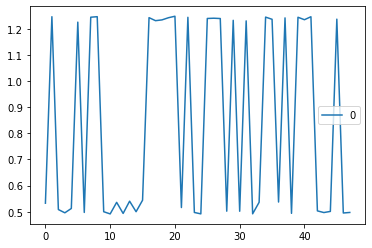

In [19]:
pd.DataFrame(distances).plot.line();

In [20]:
predicted_locations.shape

(48, 1)

In [21]:
predicted_locations

array([[ 48],
       [  0],
       [ 59],
       [ 46],
       [112],
       [194],
       [ 94],
       [ 30],
       [  2],
       [ 86],
       [ 90],
       [ 47],
       [104],
       [ 56],
       [ 45],
       [ 46],
       [ 14],
       [ 34],
       [ 15],
       [168],
       [180],
       [ 81],
       [ 46],
       [ 57],
       [ 78],
       [ 40],
       [ 12],
       [  9],
       [ 82],
       [180],
       [ 51],
       [163],
       [ 61],
       [ 78],
       [  3],
       [199],
       [ 43],
       [ 33],
       [ 91],
       [ 42],
       [192],
       [ 57],
       [ 85],
       [ 69],
       [103],
       [157],
       [ 89],
       [ 90]])

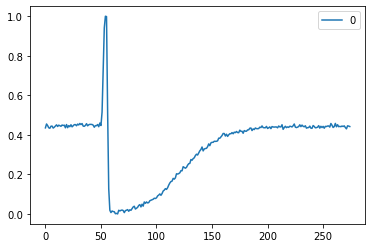

In [22]:
pd.DataFrame(X_train[0]).plot.line();

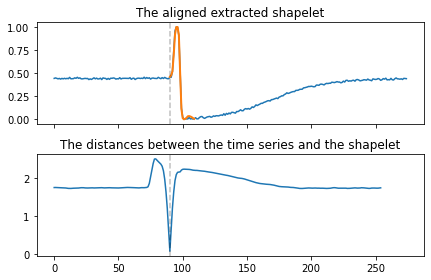

In [23]:
f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = np.argmin(np.sum(distances, axis=1))
shap = shp_clf.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances)
ax[1].axvline(np.argmin(distances), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

In [24]:
test_ts_id

10

In [25]:
shp_clf.shapelets_[0]

array([[ 0.64592773],
       [ 0.69375932],
       [ 0.82164747],
       [ 1.3284868 ],
       [ 1.96636689],
       [ 2.19802642],
       [ 2.19936848],
       [ 1.9534533 ],
       [ 0.75503051],
       [-0.35565361],
       [-0.63957649],
       [-0.67440182],
       [-0.65572757],
       [-0.6256941 ],
       [-0.57852656],
       [-0.57295638],
       [-0.58674657],
       [-0.60689217],
       [-0.63620782],
       [-0.65891647]])